<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/RandomForestClassifier/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Random Forest Classifier

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [111]:
# 1. Obtenção dos Dados
# Usando 'period' para pegar os dados dos últimos 2 anos
dados = pd.read_csv('https://raw.githubusercontent.com/willianncardoso/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
1,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"
2,02.07.2025,139.051,139.586,140.049,138.384,"8,81B","-0,36%"
3,01.07.2025,139.549,138.855,139.695,138.855,"6,35B","0,50%"
4,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"


In [112]:
def converter_volume_simples(valor):
    # Deixa tudo maiúsculo, troca vírgula por ponto e remove espaços
    valor_str = str(valor).upper().replace(',', '.').strip()

    if 'B' in valor_str:
        return int(float(valor_str.replace('B', '')) * 1_000_000_000)
    elif 'M' in valor_str:
        return int(float(valor_str.replace('M', '')) * 1_000_000)
    else:
        # Se não tiver letra, apenas converte para número
        return int(float(valor_str))

# 2. Aplique a função diretamente na coluna 'Volume'
dados['Vol.'] = dados['Vol.'].apply(converter_volume_simples)

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      502 non-null    object 
 1   Último    502 non-null    float64
 2   Abertura  502 non-null    float64
 3   Máxima    502 non-null    float64
 4   Mínima    502 non-null    float64
 5   Vol.      502 non-null    int64  
 6   Var%      502 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 27.6+ KB


In [113]:
dados['Var%'] = pd.to_numeric(dados['Var%'].str.replace('%', '').str.replace(',', '.')) / 100

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      502 non-null    object 
 1   Último    502 non-null    float64
 2   Abertura  502 non-null    float64
 3   Máxima    502 non-null    float64
 4   Mínima    502 non-null    float64
 5   Vol.      502 non-null    int64  
 6   Var%      502 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB


In [114]:
# 2. Engenharia de Atributos para Classificação

# Criando a variável-alvo (Target)
# 1 se o preço de fechamento de amanhã for MAIOR que o de hoje, 0 caso contrário
dados['Target'] = (dados['Último'].shift(-1) > dados['Último']).astype(int)

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [115]:
# 3. Criação das Variáveis Preditivas (Features)

# Lags (preços dos dias anteriores)
# for i in range(1, 6):
#     dados[f'Lag_{i}'] = dados['Último'].shift(i)

# # Médias Móveis
# dados['SMA_10'] = dados['Último'].rolling(window=10).mean()
# dados['SMA_30'] = dados['Último'].rolling(window=30).mean()

# Volatilidade (desvio padrão dos retornos em uma janela)
# dados['Volatility_10'] = dados['Daily_Return'].rolling(window=10).std()

# Remover linhas com NaN gerados pelas features
dados.dropna(inplace=True)

print("\n--- Dados Finais com Features ---")
dados


--- Dados Finais com Features ---


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target
0,04.07.2025,141.264,140.928,141.564,140.597,3310000000,0.0024,0
1,03.07.2025,140.928,139.051,141.304,139.051,6080000000,0.0135,0
2,02.07.2025,139.051,139.586,140.049,138.384,8810000000,-0.0036,1
3,01.07.2025,139.549,138.855,139.695,138.855,6350000000,0.0050,0
4,30.06.2025,138.855,136.865,139.103,136.430,7680000000,0.0145,0
...,...,...,...,...,...,...,...,...
497,06.07.2023,117.426,119.548,119.548,117.096,11030000,-0.0178,1
498,05.07.2023,119.549,119.072,120.200,118.688,10960000,0.0040,0
499,04.07.2023,119.076,119.673,119.678,118.830,6560000,-0.0050,1
500,03.07.2023,119.673,118.092,119.877,118.092,8910000,0.0134,0


In [116]:
# 4. Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target','Var%']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 401 amostras
Tamanho do conjunto de Teste: 101 amostras


In [117]:
# Verificar onde há vazamento de dados
print("--- Verificando as colunas em X antes do treino ---")
print(X_treino.columns.tolist())


--- Verificando as colunas em X antes do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']


In [118]:
# 5. Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [119]:
# Verificar onde há vazamento de dados
print("\n--- Verificando as colunas em X depois do treino ---")
print(X_teste.columns.tolist())


--- Verificando as colunas em X depois do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']



--- Resultados da Avaliação ---
Acurácia do Modelo: 50.50%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       0.49      0.94      0.64        48
       Subiu (1)       0.67      0.11      0.19        53

        accuracy                           0.50       101
       macro avg       0.58      0.53      0.42       101
    weighted avg       0.58      0.50      0.41       101


Matriz de Confusão:


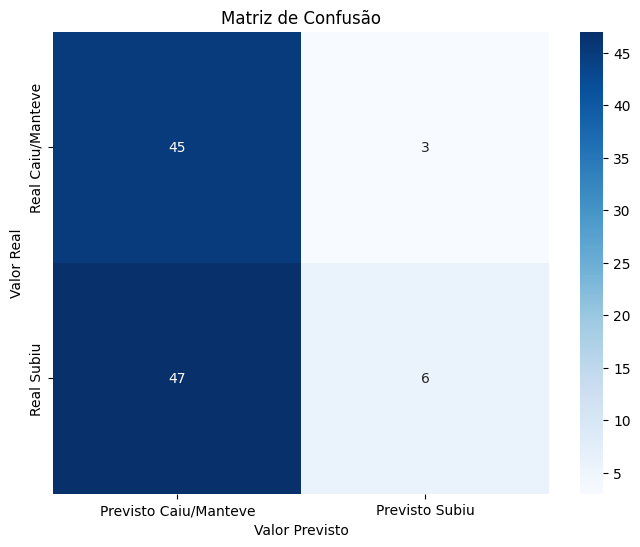

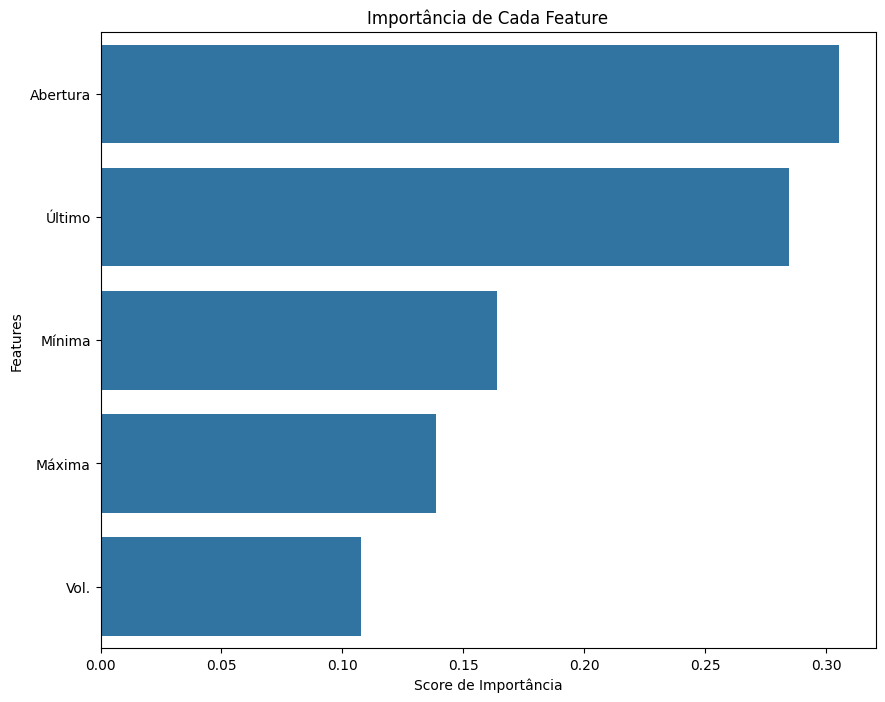

In [120]:
# 6. Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()


--- Importância das Features ---
Abertura    0.305124
Último      0.284501
Mínima      0.163767
Máxima      0.138868
Vol.        0.107739
dtype: float64


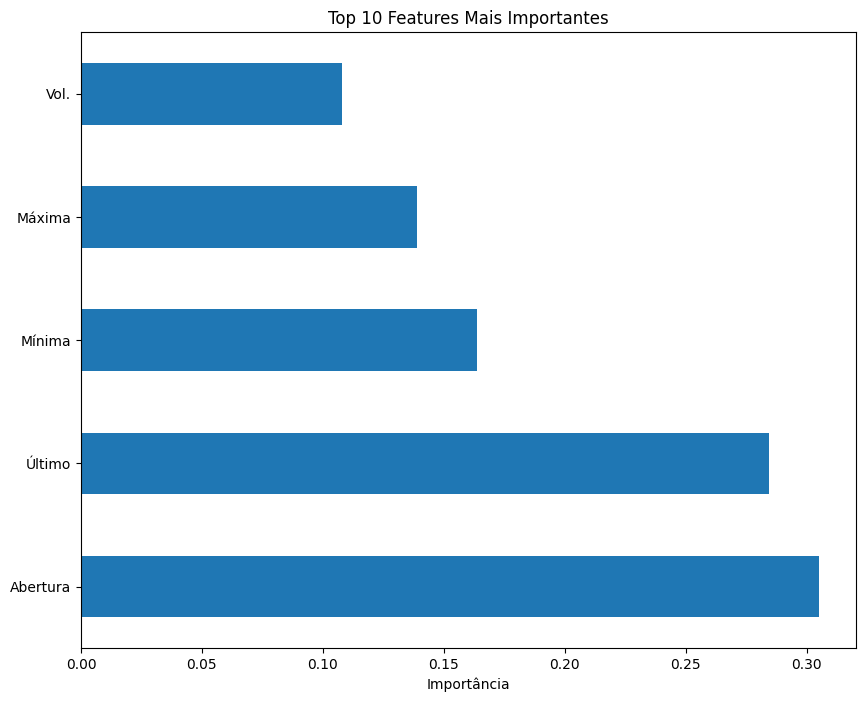

In [121]:
# Pega a importância de cada feature
importancias = pd.Series(modelo.feature_importances_, index=X_treino.columns)

# Ordena da mais importante para a menos importante
importancias_ordenadas = importancias.sort_values(ascending=False)

print("\n--- Importância das Features ---")
print(importancias_ordenadas.head(10))

# Plota o gráfico para visualização
importancias_ordenadas.head(10).plot(kind='barh', figsize=(10, 8))
plt.title('Top 10 Features Mais Importantes')
plt.xlabel('Importância')
plt.show()

In [122]:
# !pip install pandas_ta
# !pip install yfinance

In [123]:
# IMportar biblioteca com indicadores
# import pandas_ta as ta
# import yfinance as yf


# Adicionando um conjunto de indicadores técnicos populares com uma única linha de código
# dados.ta.strategy("common", append=True)

# # Vamos adicionar mais alguns úteis individualmente
# dados.ta.macd(append=True) # Moving Average Convergence Divergence
# dados.ta.rsi(append=True)  # Relative Strength Index

# # Adicionar o contexto do mercado geral (Ibovespa)
# ibov = yf.download('^BVSP', period='2y', auto_adjust=True)
# # Calcular o retorno diário do Ibovespa e adicionar aos nossos dados
# dados['IBOV_Return'] = ibov['Close'].pct_change()

# # Remover as linhas com valores NaN que foram geradas
# dados.dropna(inplace=True)

# print("\n--- Colunas disponíveis após adicionar indicadores ---")
# print(dados.columns)

In [124]:
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target
0,04.07.2025,141.264,140.928,141.564,140.597,3310000000,0.0024,0
1,03.07.2025,140.928,139.051,141.304,139.051,6080000000,0.0135,0
2,02.07.2025,139.051,139.586,140.049,138.384,8810000000,-0.0036,1
3,01.07.2025,139.549,138.855,139.695,138.855,6350000000,0.0050,0
4,30.06.2025,138.855,136.865,139.103,136.430,7680000000,0.0145,0
